### Preprocessing the Payloads 

*Each payload is converted into a numpy array based on its ascii decimal value*
*Payloads with less than length of 200 are padded with additional 0s at the end and each payload is at most 200 characters long*
*The payloads are then scaled down to be in between 0 - 1 to make it grayscale image* 

In [1]:
# Imports 
import os 
import PIL
import glob
import time
import imageio
import numpy as np 
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    LeakyReLU,
    Reshape,
    Conv2DTranspose,
    Conv2D,
    Dropout,
    Flatten
)


In [2]:
# Constants 
DATASET_DIR = "datasets"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR = os.path.join(DATASET_DIR, "test")
VALIDATION_DIR = os.path.join(DATASET_DIR, "val")
CHECK_POINT_DIR = "checkpoints"
BUFFER_SIZE = 1000
BATCH_SIZE = 256

*Open each file in the dataset folder convert the payloads to numeric format using their ascii representation and save them in a global list*

In [3]:
class PreprocessPayloads(object):
    def open_payload_file_and_read_lines(self, filename):
        with open(filename, 'r', encoding='utf-8') as file:
            payloads = file.readlines()
        return payloads


    def convert_payloads_to_assci(self, filename):
        payloads = self.open_payload_file_and_read_lines(filename)
        ascii_payloads = []
        for payload in payloads:
            ascii_payloads.append([ord(c) / 255.0 for c in payload])
        return ascii_payloads


    def pad_payloads(self, filename):
        ascii_payloads = self.convert_payloads_to_assci(filename)
        for payload in ascii_payloads:
            if len(payload) < 200:
                for i in range(200 - len(payload)):
                    payload.append(0 / 255.0)
        return ascii_payloads


    def get_payload_matrix(self, filename):
        payloads = self.pad_payloads(filename)
        converted_payloads = []
        for payload in payloads:
            payload = np.asarray(payload)
            payload = np.reshape(payload, (10, 20))
            converted_payloads.append(payload)
        matrix = np.asarray(converted_payloads)
        matrix = matrix.reshape(matrix.shape + (1,))
        return matrix

        
        
preprocess = PreprocessPayloads()
training_images = preprocess.get_payload_matrix(os.path.join(TRAIN_DIR, "training_set.txt"))
print(training_images[0], type(training_images[0]),training_images[0].shape)


[[[0.13333333]
  [0.17647059]
  [0.43921569]
  [0.44705882]
  [0.43529412]
  [0.42745098]
  [0.43921569]
  [0.45490196]
  [0.15686275]
  [0.21960784]
  [0.16078431]
  [0.17647059]
  [0.13333333]
  [0.03921569]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0

### Plot the generated numpy matrics to get the visual representation

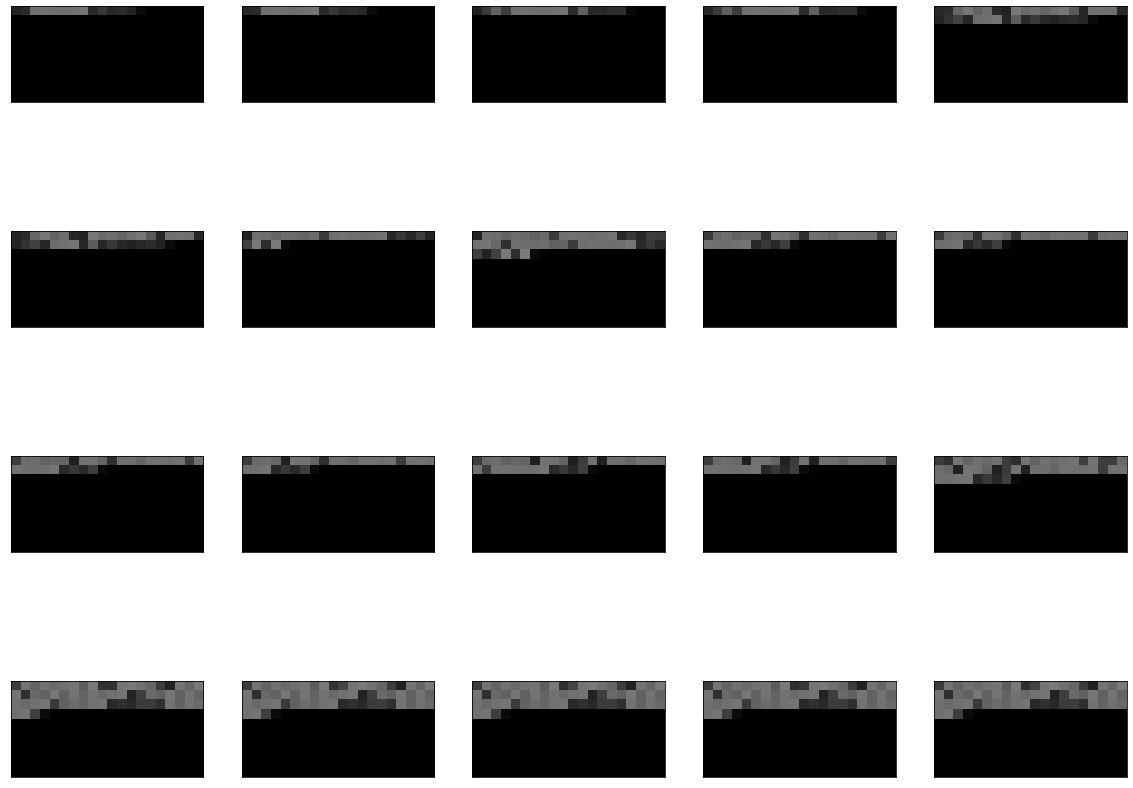

In [4]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()


In [16]:
# Save the payloads images to directory 
training_images = preprocess.get_payload_matrix(os.path.join(TRAIN_DIR, 'training_set.txt'))
validation_images = preprocess.get_payload_matrix(os.path.join(VALIDATION_DIR, 'validation_set.txt'))
testing_images = preprocess.get_payload_matrix(os.path.join(TEST_DIR, 'testing_set.txt')) 

# Save the matrix to a file 
np.save(os.path.join(TRAIN_DIR, 'training_set_numpy.npy'), training_images)
np.save(os.path.join(VALIDATION_DIR, 'validation_set_numpy.npy'), validation_images)
np.save(os.path.join(TEST_DIR, 'testing_set_numpy.npy'), testing_images)

# Normalize the images
training_images = (training_images - 127.5) / 127.5 
training_images.shape


(700, 10, 20, 1)

In [17]:
# Batch and Shuffle the data
training_dataset = tf.data.Dataset.from_tensor_slices(training_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
training_dataset

<BatchDataset shapes: (None, 10, 20, 1), types: tf.float64>

In [18]:
# Generator Model
def generator_model():
    model = tf.keras.models.Sequential()
    model.add(Dense(5*10*256, use_bias=False, input_shape=(200,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Reshape((5, 10, 256)))
    assert model.output_shape == (None, 5, 10, 256) # None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 5, 10, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 10, 20, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 10, 20, 1)

    return model 


generator = generator_model()
generator.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12800)             2560000   
                                                                 
 batch_normalization_3 (Batc  (None, 12800)            51200     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12800)             0         
                                                                 
 reshape_1 (Reshape)         (None, 5, 10, 256)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 5, 10, 128)       819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 5, 10, 128)      

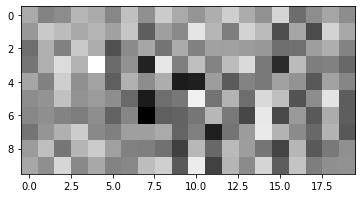

In [19]:
# Train the generator with noise 
noise = tf.random.normal([1, 200])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()


In [20]:
def discriminator_model():
    model = tf.keras.models.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[10, 20, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(5, 5), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1))

    return model 

discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 5, 10, 64)         1664      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 5, 10, 64)         0         
                                                                 
 dropout_3 (Dropout)         (None, 5, 10, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 5, 128)         204928    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 3, 5, 128)         0         
                                                                 
 dropout_4 (Dropout)         (None, 3, 5, 128)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 3, 256)        

In [22]:
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49972084]], dtype=float32)>

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_prefix = os.path.join(CHECK_POINT_DIR, 'ckpt')
checkpoint = tf.train.Checkpoint(
    genertor_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generartor=generator,
    discriminator=discriminator
)

In [18]:
EPOCHS = 60
num_examples_to_generate = 15
noise_dimension = 200
seed = tf.random.normal([num_examples_to_generate, noise_dimension])

In [19]:
@tf.function
def training_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        print(f"generator loss: {gen_loss}  discriminator loss: {disc_loss}")


In [20]:
def save_generated_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('./generated_images/images_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    return predictions

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            training_step(image_batch)
        display.clear_output(wait=True)
        save_generated_images(generator, epoch+1, seed)
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    display.clear_output(wait=True)
    return save_generated_images(generator, epochs, seed)


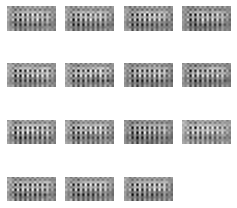

In [22]:
predictions = train(training_dataset, EPOCHS)
checkpoint.restore(tf.train.latest_checkpoint(CHECK_POINT_DIR))

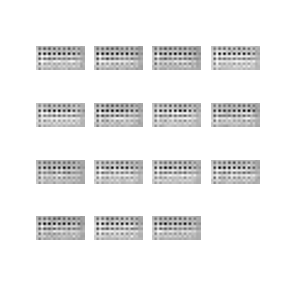

In [78]:
def display_payloads(epoch_number):
    return PIL.Image.open('./generated_images/images_at_epoch_{:04d}.png'.format(epoch_number))
display_payloads(EPOCHS)

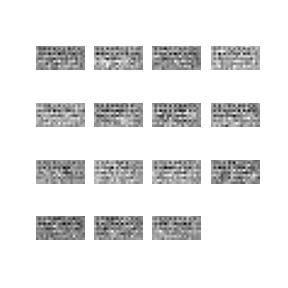

In [79]:
gif_file = "payload_gan.gif"

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob('./generated_images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
display.Image(open('payload_gan.gif', 'rb').read())


In [80]:
predictions

<tf.Tensor: shape=(15, 10, 20, 1), dtype=float32, numpy=
array([[[[ 0.3535487 ],
         [-0.05138984],
         [ 0.6381638 ],
         ...,
         [ 0.41105086],
         [ 0.01526735],
         [ 0.24549226]],

        [[ 0.6224728 ],
         [-1.6705422 ],
         [ 0.34647536],
         ...,
         [-1.1141757 ],
         [-0.08853764],
         [-0.10057876]],

        [[ 0.99920064],
         [ 0.73506194],
         [ 1.1928712 ],
         ...,
         [ 0.7438515 ],
         [-0.21473312],
         [ 0.01725035]],

        ...,

        [[ 1.4051734 ],
         [-1.6273438 ],
         [ 1.5966122 ],
         ...,
         [ 0.4682545 ],
         [-0.08276733],
         [ 0.41560316]],

        [[ 0.7751772 ],
         [ 0.8937384 ],
         [ 1.038739  ],
         ...,
         [ 0.9757967 ],
         [-0.22228128],
         [ 0.2036669 ]],

        [[ 0.9043592 ],
         [-0.82497036],
         [ 0.92122465],
         ...,
         [ 0.10612095],
         [ 0.200715

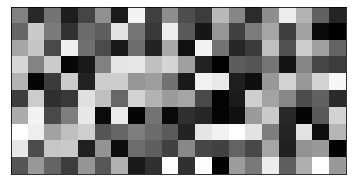

In [81]:
# predictions = (predictions + 127.5) 
first_prediction = predictions[0]
first_prediction = ((first_prediction + 0.1) * (1/0.3) * 255)
first_prediction = np.uint8(first_prediction)
# first_prediction.shape
# First predictions 
plt.imshow(first_prediction, cmap='gray')
plt.grid('off')
plt.xticks([])
plt.yticks([])
plt.show()

In [82]:
first_prediction_list = first_prediction.flatten().tolist()
len(first_prediction_list)

200

In [83]:
def convert_ascii_to_readable(ascii_list):
    payload = ""
    for ascii in ascii_list:
        # payload += chr(int(ascii))
        print(chr(ascii))
    return payload

print(convert_ascii_to_readable(first_prediction_list))
# first_prediction_list



)
s

E


ó
@

N
=
¹

+

í
²
a
%
f
Ê
{
2
l
^
ä
t
9
í
Y


@
|
¥
>
¢
	
 
¦
Å
J
ï
p
K

m
#
ª

ó
s
&
;
¿
R
Í

c
×

Ë



å
ç
À
Õ
 
"

]
U
u


E
=
´

;
Ë
"
Í
Í


q

ò
é



Ò

Ô
÷
<
Ì
/
9
à
À
g
Ó
´

¥
J


Ï
£

L
a
*
¬
ô
J
~
è

ê

s
	
/
&



Ê
)

Y
Ô
ÿ
î
¢
¿
Î
U
e
~
k
[
#
å
ò
ÿ
ä
~
$
ã

¶
ç
L
Ç
É
 


m
_
B

F
A
c
H
¥
!



U

d
=

V
±

0
ÿ
1
ý


z
í
^
¯
ÿ


